In [1]:
import sys
!{sys.executable} --version

import os
import math
from math import log
# import pickle
import numpy as np
from hurst import compute_Hc
from arch import arch_model
from IPython.display import display
import matplotlib.pyplot as plt

import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from IPython.display import display

%matplotlib inline

from quantile_functions import *
from VaR_backtest_tests import *

Python 3.8.8


In [24]:
ticker = ['GME']
start = '2015-1-1'
end = '2021-9-4'
ticker_df = yf.download(tiker,start,end,process=True,auto_adjust=True)
display(ticker_df.head())
display(ticker_df.tail())

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2014-12-31,25.475866,25.609832,25.088853,25.155836,1614800
2015-01-02,25.349344,25.423769,24.746496,25.155836,1612700
2015-01-05,24.947444,25.959632,24.806037,25.840551,4934900
2015-01-06,26.175459,26.815519,24.947439,25.073961,4885100
2015-01-07,25.520517,25.810776,24.545541,24.783703,2558300


,Open,High,Low,Close,Volume
Date,,,,,
2021-08-30,205.000000,218.190002,203.020004,209.199997,3309600
2021-08-31,212.699997,222.300003,211.460007,218.240005,3574700
2021-09-01,224.000000,231.440002,208.020004,212.970001,4453800
2021-09-02,213.860001,214.800003,206.300003,213.520004,1852000
2021-09-03,212.050003,216.270004,198.839996,202.750000,2658600


Date
2015-01-02    0.000000
2015-01-05    0.026855
2015-01-06   -0.030115
2015-01-07   -0.011644
2015-01-08    0.011644
                ...   
2021-08-30    0.020525
2021-08-31    0.042305
2021-09-01   -0.024444
2021-09-02    0.002579
2021-09-03   -0.051757
Name: Close, Length: 1681, dtype: float64

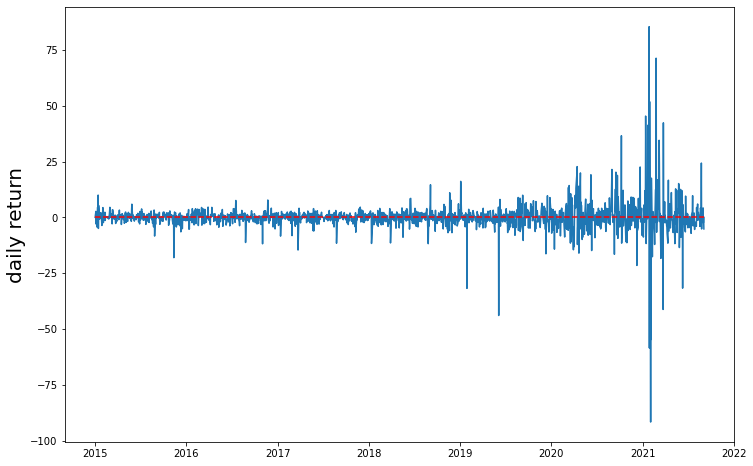

In [25]:
returns = ticker_df['Close'].apply(log).diff()[1:]
train1 = returns*100
train2 = train1**2
plt.figure(figsize=(12,8))
plt.plot(train1)
plt.plot([train1.index[0],train1.index[-1]],[0,0],'--',color='red')
plt.ylabel('daily return',fontsize=20)
display(returns)

# 120Day moving average 95% VAR

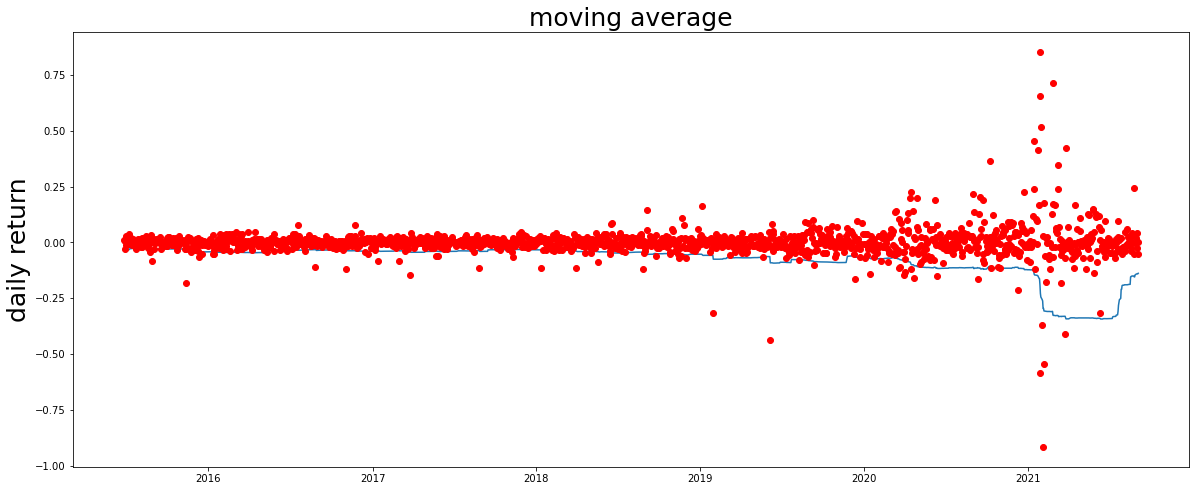

,VaR,returns
Date,,
2021-09-01,-0.141102,-0.024444
2021-09-02,-0.141126,0.002579
2021-09-03,-0.138424,-0.051757


In [104]:
p = 0.05
train = returns
train2 = train * train

history_n = 120   

# calculate 95% VaR
MAVaR = [-1.64 * np.sqrt(np.mean(train2[i+1:i+history_n+1])) for i,_ in enumerate(train2[:-history_n-1])]
MAVaR_df = pd.DataFrame(MAVaR[:], index=pd.DataFrame(train).index[history_n+1:], columns=['VaR'])
MAVaR_df['returns'] = train[1:]

plt.figure(figsize=(20,8))
start_date = '2015-01-01'
plt.plot(MAVaR_df[start_date:]['VaR'])
plt.plot(MAVaR_df[start_date:]['returns'], 'ro')
plt.title("moving average", fontsize=25)
plt.ylabel('daily return', fontsize=25)
plt.show()

display(MAVaR_df[-3:])

# Count exceptions for MA120

In [105]:
MAV2020 = MAVaR_df[MAVaR_df.index >= '2020-01-01']
MAV2020.loc[:,'exception'] = MAV2020['returns'] < MAV2020['VaR']
print(ticker, ': number of exceptions = ', MAV2020['exception'].sum(), ' out of ', MAV2020.shape[0], 'days')
MAV2020[-5:]


['GME'] : number of exceptions =  18  out of  423 days


F:\Anaconda\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
F:\Anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


423

In [60]:
from scipy.stats import chi2
m = 18
n = 423
p = 0.05

def LR_uc(m,n,p):
    first = -2*math.log((1-p)**(n-m)*p**m)
    second = 2*math.log((1-m/n)**(n-m)*(m/n)**m)
    return first+second
LR_uc(m,n,p)
chidf1 = chi2.ppf(0.95, df=1)
if LR_uc(m,n,p)<=chidf1:
    print('The LRus statistic:',LR_uc(m,n,p),' is less than Chi-square statistic of df=1',chidf1,'.That is our 95% VAR is not rejected')

The LRus statistic: 0.5189744692671638  is less than Chi-square statistic of df=1 3.841458820694124 .That is our 95% VAR is not rejected


# EWMA 95% VAR

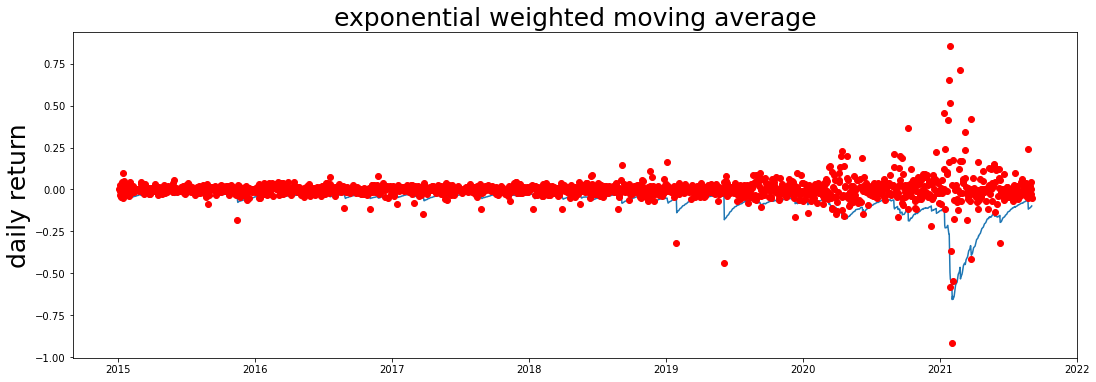

['GME'] : number of exceptions =  13  out of  423 days


F:\Anaconda\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
F:\Anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,vol,VaR,returns,exception
Date,,,,
2020-01-14,0.001960,-0.072605,-0.142251,True
2020-02-07,0.001658,-0.066784,-0.083067,True
2020-02-24,0.001364,-0.060573,-0.087912,True
2020-03-18,0.003453,-0.096368,-0.115127,True
2020-03-30,0.004285,-0.107354,-0.145108,True
2020-04-02,0.005104,-0.117167,-0.131336,True
2020-06-11,0.005510,-0.121735,-0.148578,True
2020-09-10,0.003834,-0.101542,-0.165324,True
2020-12-09,0.003596,-0.098345,-0.215206,True


In [90]:
p = 0.05
train = returns
train2 = train * train

wt = .94
vol = train2[0]
vol_history = [0,vol]  # move everything forward one day
for v in train2[1:]:
    vol = wt * vol + (1 - wt) * v
    vol_history.append(vol)
    
EWMA_df = pd.DataFrame(vol_history[:-1], index=train.index, columns=['vol'])
EWMA_df['VaR'] = [-1.64 * math.sqrt(x) for x in EWMA_df['vol']]
EWMA_df['returns'] = train

plt.figure(figsize=(18,6))
plt.plot(EWMA_df['2015-01-01':]['VaR'])
plt.plot(EWMA_df['2015-01-01':]['returns'], 'ro')
plt.title('exponential weighted moving average', fontsize=25)
plt.ylabel('daily return', fontsize=25)
plt.show()

EWMA2020 = EWMA_df[EWMA_df.index >= '2020-01-01']
EWMA2020.loc[:,'exception'] = EWMA2020['returns'] < EWMA2020['VaR']

exception_df = EWMA2020[EWMA2020['exception'].isin([1])]

print(ticker, ': number of exceptions = ', EWMA2020['exception'].sum(), ' out of ', EWMA2020.shape[0], 'days')
display(exception_df)

In [72]:
from scipy.stats import chi2
m = 13
n = 423
p = 0.05

def LR_uc(m,n,p):
    first = -2*math.log((1-p)**(n-m)*p**m)
    second = 2*math.log((1-m/n)**(n-m)*(m/n)**m)
    return first+second

chidf1 = chi2.ppf(0.95, df=1)
if LR_uc(m,n,p)<=chidf1:
    print('The LRus statistic:',LR_uc(m,n,p),' is less than Chi-square statistic of df=1',chidf1,'.That is our 95% VAR is not rejected')
else:
        print('The LRus statistic:',LR_uc(m,n,p),' is greater than Chi-square statistic of df=1',chidf1,'.That is our 95% VAR is rejected')

The LRus statistic: 3.8102312836938523  is less than Chi-square statistic of df=1 3.841458820694124 .That is our 95% VAR is not rejected


# GARCH(1,1) 95% VAR

Iteration:      1,   Func. Count:      5,   Neg. LLF: 10835.650559023627
Iteration:      2,   Func. Count:     10,   Neg. LLF: 8627.234630942115
Iteration:      3,   Func. Count:     14,   Neg. LLF: 8626.99853301871
Iteration:      4,   Func. Count:     18,   Neg. LLF: 8626.819263723615
Iteration:      5,   Func. Count:     22,   Neg. LLF: 8625.932287669648
Iteration:      6,   Func. Count:     26,   Neg. LLF: 8622.234346701307
Iteration:      7,   Func. Count:     30,   Neg. LLF: 8626.626948802144
Iteration:      8,   Func. Count:     35,   Neg. LLF: 8619.801139291625
Iteration:      9,   Func. Count:     39,   Neg. LLF: 8619.730843312866
Iteration:     10,   Func. Count:     43,   Neg. LLF: 8619.726536911567
Iteration:     11,   Func. Count:     47,   Neg. LLF: 8619.72629213157
Iteration:     12,   Func. Count:     51,   Neg. LLF: 8619.72628752563
Iteration:     13,   Func. Count:     55,   Neg. LLF: 8619.72628779685
Optimization terminated successfully    (Exit mode 0)
            C

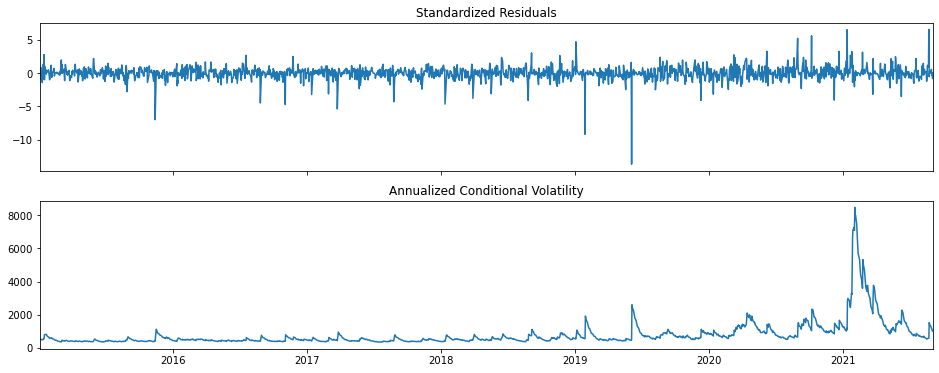

In [97]:
scale_factor = 1000
train = returns * scale_factor   # rescale for algorithm to converge

model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1)
res = model.fit(last_obs='2021-9-4')
print(res.summary())
plt.rc("figure", figsize=(16, 6))
fig = res.plot(annualize='D')
print(res.params, res.tvalues, res._params, res._names)

In [98]:
display(pd.DataFrame(res.params))
persistence = res.params['alpha[1]'] + res.params['beta[1]']
print(f"\npersistence = {persistence:0.3} (speed of mean reversion see Jorion Fig 9-6 page 229)")
print(f"unconditional variance = {res.params['omega'] / ( 1 - persistence): 0.3}")

,params
omega,51.877170
alpha[1],0.134291
beta[1],0.865709



persistence = 1.0 (speed of mean reversion see Jorion Fig 9-6 page 229)
unconditional variance = -1.08e+12


F:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


,VaR,returns
Date,,
2020-01-03,-0.085045,-0.070579
2020-01-06,-0.090618,-0.005115
2020-01-07,-0.085198,-0.058064
2020-01-08,-0.087460,0.035591
2020-01-09,-0.084986,-0.030171
...,...,...
2021-08-30,-0.132088,0.020525
2021-08-31,-0.124088,0.042305
2021-09-01,-0.118830,-0.024444


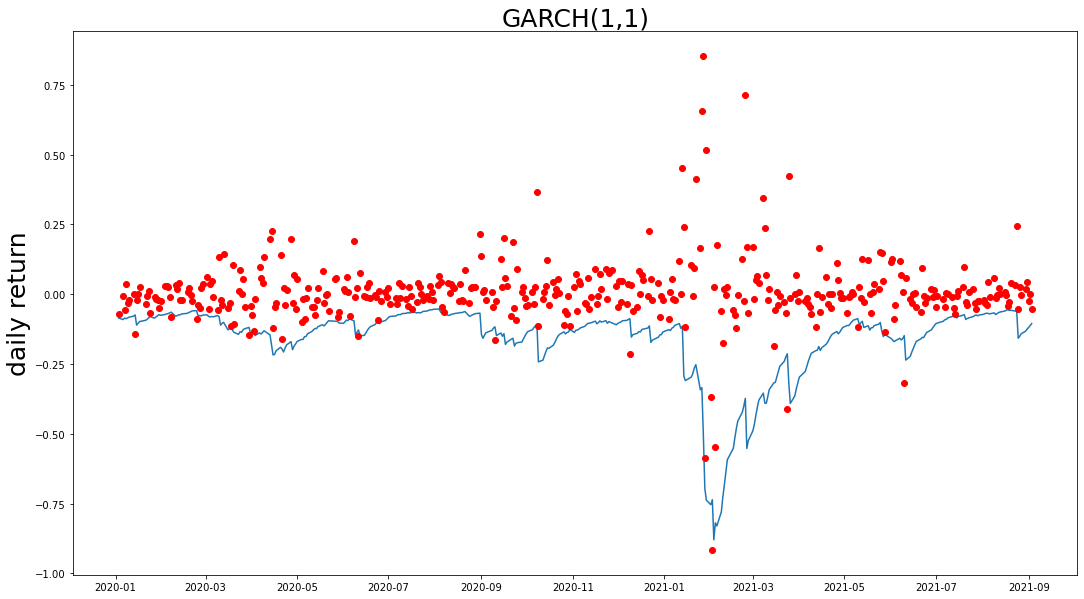

In [99]:
forecasts = res.forecast(start='2020-01-01') # .variance['h.1']

cond_mean = forecasts.mean['2020-01-01':]
cond_var = forecasts.variance['2020-01-01':]
q = model.distribution.ppf([p]) # -1.645 for p=0.05

GARCH_df = pd.DataFrame([-x[0] / scale_factor for x in 
                         (-cond_mean.values - np.sqrt(cond_var).values * q)[:-1]], 
                             index=train['2020-01-01':].index[1:], columns=['VaR'])

GARCH_df['returns'] = train['2020-01-01':] / scale_factor
display(GARCH_df)

plt.figure(figsize=(18,10))
plt.plot(GARCH_df['VaR'])
plt.plot(GARCH_df['returns'], 'ro')
plt.title('GARCH(1,1)', fontsize=25)
plt.ylabel('daily return', fontsize=25)
plt.show()

In [100]:
GARCH2020 = GARCH_df[GARCH_df.index >= '2020-01-01']
GARCH2020.loc[:,'exception'] = GARCH2020['returns'] < GARCH2020['VaR']
print(ticker, ': number of exceptions = ', GARCH2020['exception'].sum(), ' out of ', GARCH2020.shape[0], 'days')

['GME'] : number of exceptions =  11  out of  422 days


In [106]:
from scipy.stats import chi2
m = 13
n = 422
p = 0.05

def LR_uc(m,n,p):
    first = -2*math.log((1-p)**(n-m)*p**m)
    second = 2*math.log((1-m/n)**(n-m)*(m/n)**m)
    return first+second

chidf1 = chi2.ppf(0.95, df=1)
if LR_uc(m,n,p)<=chidf1:
    print('The LRus statistic:',LR_uc(m,n,p),' is less than Chi-square statistic of df=1',chidf1,'.That is our 95% VAR is not rejected')
else:
        print('The LRus statistic:',LR_uc(m,n,p),' is greater than Chi-square statistic of df=1',chidf1,'.That is our 95% VAR is rejected')

The LRus statistic: 3.7701498120379284  is less than Chi-square statistic of df=1 3.841458820694124 .That is our 95% VAR is not rejected


In [ ]:
##To conclusion, all of the three models are not acceptable because all of the LRus statistics are less than 3.841

# Using EWMA to calculate ETL, VAR and MAXVAR

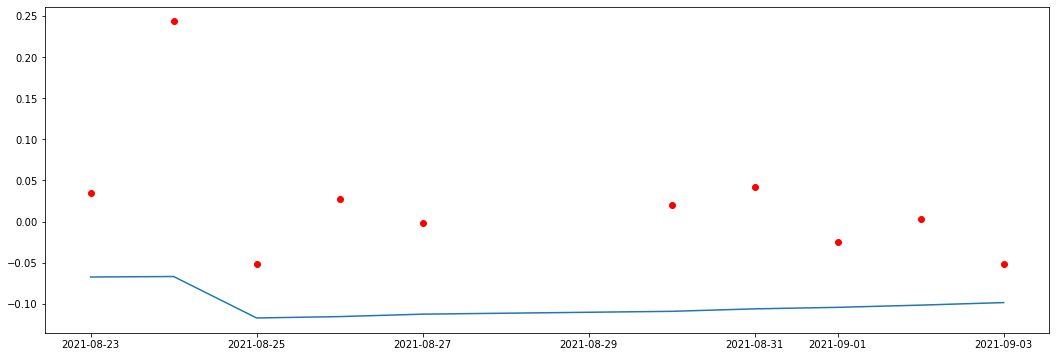

In [111]:
wt = .94
vol = train2[0]
vol_history = [0,vol]  # move everything forward one day
for v in train2[1:]:
    vol = wt * vol + (1 - wt) * v
    vol_history.append(vol)
    
EWMA_df = pd.DataFrame(vol_history[:-1], index=train.index, columns=['vol'])
EWMA_df['VaR'] = [-1.64 * math.sqrt(x) for x in EWMA_df['vol']]
EWMA_df['returns'] = train
plt.figure(figsize=(18,6))
plt.plot(EWMA_df['2021-08-21':]['VaR'])
plt.plot(EWMA_df['2021-08-21':]['returns'], 'ro')



In [152]:
ten_days_returns_mean = EWMA_df.iloc[cols-10:cols,:]['returns'].mean()


mu_h = ten_days_returns_mean # this is the mean of % returns over 10 days 
sig_h = sigma # this is the vol over the horizon
alpha = 0.05
T = 10 #of days

sigma = EWMA_df['returns'].iloc[-1]
VAR = 1.64*sigma*math.sqrt(T)-mu_h
MAXVAR = 1.96*sigma*math.sqrt(T)
ETL = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_h*math.sqrt(T) - mu_h

cols = EWMA_df.shape[0]
print('The 95% of 10-days VAR is',VAR)
print('The 95% of 10-days MAXVAR is',MAXVAR)
print('The 95% of 10-days ETL is',ETL)

The 95% of 10-days VAR is -0.29253638296005174
The 95% of 10-days MAXVAR is -0.32079216892984525
The 95% of 10-days ETL is -0.3617215657940983
